Let's start by using PyNvVideoCodec first to see how's the decoding and encoding works

https://docs.nvidia.com/video-technologies/pynvvideocodec/pynvc-api-prog-guide/index.html

# Installation
- Use the latest Nvidia GPU Driver
- Use conda to create env

```bash
pip install PyNvVideoCodec numpy pycuda jupyterlab opencv-python matplotlib pillow
```

In [5]:
# No stub
import PyNvVideoCodec as nvc
import pycuda.driver as cuda

enc_file_path = "../assets/test.mp4"

demuxer = nvc.CreateDemuxer(filename=enc_file_path)

# These are the raw encode packet
# for packet in demuxer:
#     print(packet)
#     break

key:      0
pts:      0
dts:      0
pos:      0
bsl:      122331
bsl_data:      33238096
duration: 0

[INFO ][18:54:01] Media format: QuickTime / MOV (mov,mp4,m4a,3gp,3g2,mj2)
[WARN ][18:54:01] ChromaFormat not recognized. Assuming 420


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x1f60a40] Could not find codec parameters for stream 1 (Audio: mp3 (mp4a / 0x6134706D), 44100 Hz, 2 channels, 127 kb/s): unspecified frame size
Consider increasing the value for the 'analyzeduration' (0) and 'probesize' (5000000) options
[NULL @ 0x234b280] No codec provided to avcodec_open2()


In [ ]:
# Refer to cuda programming for cuda context and cuda stream
decoder = nvc.CreateDecoder(gpuid=0,
                            codec=nvc.cudaVideoCodec.H264,
                            cudacontext=0,
                            cudastream=0,
                            usedevicememory=True,
                            enableasyncallocations=False)

In [2]:
import PyNvVideoCodec as nvc
import pycuda.driver as cuda
import numpy as np
enc_file_path = "../assets/test.mp4"
cuda.init()
cuda_device = cuda.Device(0)
cuda_ctx = cuda_device.retain_primary_context()
cuda_ctx.push()
cuda_stream_decoder = cuda.Stream()
cuda_stream_app = cuda.Stream()

demuxer = nvc.CreateDemuxer(filename=enc_file_path)
decoder = nvc.CreateDecoder(
    gpuid=0,
    codec=nvc.cudaVideoCodec.H264,
    cudacontext=cuda_ctx.handle,
    cudastream=cuda_stream_decoder.handle,
    usedevicememory=True,
    enableasyncallocations=True
)

raw_frame = None
seq_triggered = False
for packet in demuxer:
    for decoded_frame in decoder.Decode(packet):
        if not seq_triggered:
            decoded_frame_size = decoder.GetFrameSize()
            raw_frame = cuda.pagelocked_empty(
            shape=decoded_frame_size,
            dtype=np.uint8,
            order='C',
            mem_flags=0)  # for stream aware allocations, we need to create page locked host
            # memory
            seq_triggered = True
        luma_base_addr = decoded_frame.GetPtrToPlane(0)
        decoder.WaitOnCUStream(cuda_stream_app.handle)
        cuda.memcpy_dtoh_async(
        raw_frame,
        luma_base_addr,
        cuda_stream_app)
        cuda_stream_app.synchronize()

demuxer.GetNvCodecId()

[INFO ][18:59:22] Media format: QuickTime / MOV (mov,mp4,m4a,3gp,3g2,mj2)
[WARN ][18:59:22] ChromaFormat not recognized. Assuming 420
enabling stream aware allocations!
Session Initialization Time: 25 ms 


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x38ac1c0] Could not find codec parameters for stream 1 (Audio: mp3 (mp4a / 0x6134706D), 44100 Hz, 2 channels, 127 kb/s): unspecified frame size
Consider increasing the value for the 'analyzeduration' (0) and 'probesize' (5000000) options
[NULL @ 0x3868200] No codec provided to avcodec_open2()


In [10]:
print(demuxer.GetNvCodecId())
print(demuxer.ColorRange())
print(demuxer.ColorSpace())
print(demuxer.Height())
print(demuxer.Width())
print(demuxer.FrameRate())
print(demuxer.FrameSize())

cudaVideoCodec.H264
ColorRange.UDEF
ColorSpace.UNSPEC
1080
1920
60.0
3110400


In [13]:
# Color Space https://medium.com/@reachraktim/the-data-scientist-guide-to-understanding-color-spaces-srgb-ycbcr-i420-nv12-20ee34e92b76
raw_frame.shape

(3110400,)

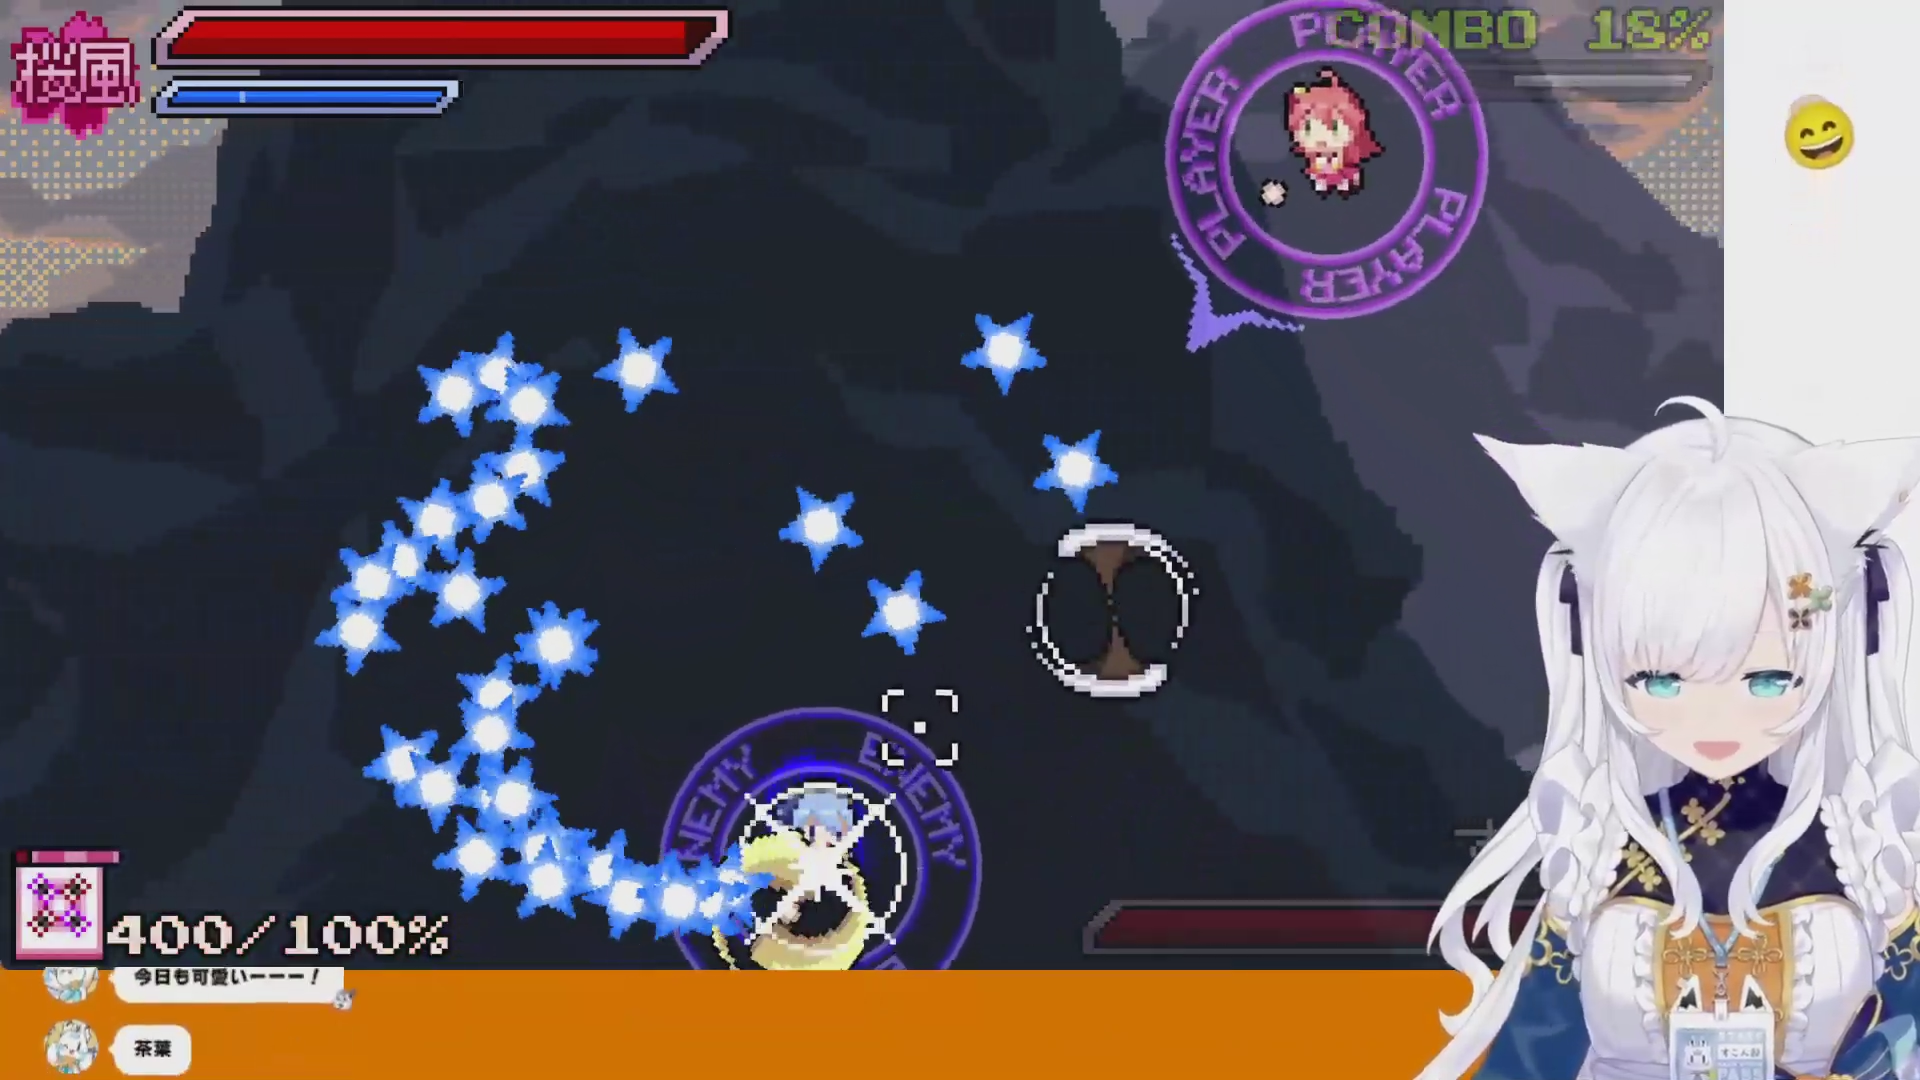

In [20]:
import cv2
from PIL import Image

def nv12_to_rgb(nv12, width, height):
    # The length of the Y plane
    y_len = width * height

    # Extract Y, U, and V planes
    y = nv12[:y_len].reshape((height, width))
    uv = nv12[y_len:].reshape((height // 2, width // 2, 2))

    # Split UV plane into U and V
    u = uv[:, :, 0]
    v = uv[:, :, 1]

    # Upsample U and V to the original resolution
    u = cv2.resize(u, (width, height), interpolation=cv2.INTER_LINEAR)
    v = cv2.resize(v, (width, height), interpolation=cv2.INTER_LINEAR)

    # Merge Y, U, and V planes into a single YUV image
    yuv = cv2.merge([y, u, v])

    # Convert YUV to RGB
    rgb = cv2.cvtColor(yuv, cv2.COLOR_YUV2RGB)

    return rgb

# Example usage
rgb_image = nv12_to_rgb(raw_frame, 1920, 1080)
im = Image.fromarray(rgb_image)
im